<a href="https://colab.research.google.com/github/claytoncohn/CoralBleaching_SkinCancer/blob/master/BinaryMultiSkinCancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created by Clayton Cohn for the purposes of detecting the existence of causal chains in the Coral Bleaching and Skin Cancer datasets using BERT.

BERT will be fine-tuned for ternary classification: 0 indicating the absense of a causal relation, 1 indicating the presence of a valid causal relation, and 2 indicating the presence an invalid causal relation. After that, it will be put through another round of classification to see if the model can identify the correct relation.

The code in this notebook is originally adopted from:

https://colab.research.google.com/drive/1ywsvwO6thOVOrfagjjfuxEf6xVRxbUNO#scrollTo=IUM0UA1qJaVB

I have adapted it for use with the Skin Cancer and Coral Bleaching datasets below:

https://knowledge.depaul.edu/display/DNLP/Tasks+and+Data
---


Mount Drive to Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the desired dataset.

In [2]:
import pandas as pd

DATA_PATH = "drive/My Drive/colab/data/"
DATA_NAME = "EBA1415-SkinCancer-big-sentences.tsv"

df = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=0, names=['essay', 'relation', 's_num', 'sentence'])
df.head(10)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,R-1-2,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,R-1-2,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,O,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,O,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,R-12-3,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,O,10.0,That would be your skin protects you.


Must transform relation labels to ternary labels.


In [3]:
relations_pd = df.relation.copy(deep=True)

relations = [
                  "1,2", "1,3", "1,4", "1,5", "1,6", "1,50",
                  "2,3", "2,4", "2,5", "2,6", "2,50",
                  "3,4", "3,5", "3,6", "3,50",
                  "4,5", "4,6", "4,50",
                  "5,6", "5,50",
                  "11,12", "11,6", "11,50",
                  "12,6", "12,50",
                  "6,50"     
                 ]

print("{} unique relations".format(len(relations)))

for i, rel in relations_pd.items():
  chain = rel.split("-")

  if chain[0] == "O":
    relations_pd.at[i] = 0
    continue
  
  chain = chain[1] + "," + chain[2]

  if chain in relations:
    relations_pd.at[i] = 1
  else: 
    relations_pd.at[i] = 2

26 unique relations


In [4]:
df_ternary = df.copy(deep=True)
df_ternary.relation = relations_pd
df_ternary.head(10)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,0,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,0,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,0,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,0,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,1,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,1,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,0,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,0,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,2,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,0,10.0,That would be your skin protects you.


Next, we must address the issue that some sentences have multiple relations. This could be a problem if a sentence has one valid relation and one invalid one (the same sentence will have multiple labels). To correct this, we will remove the duplicate instances and define each sentence to be 1 if it contains *at least one* causal relation. Otherwise, it will be classified as -1 if it has at least one invalid causal relation, and -1 otherwise.

The parse was provided by @TrentonMcKinney on StackOverflow:
https://stackoverflow.com/questions/63697275/regex-string-for-different-versions/63697498#63697498

In [5]:
df_duplicate_sentences = df_ternary[df_ternary.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences.head(25)

,essay,relation,s_num,sentence
25,EBA1415_SDMK_6_SC_ES-06292,1,26.1,If you are between the Tropics of Cancer and c...
26,EBA1415_SDMK_6_SC_ES-06292,1,26.2,If you are between the Tropics of Cancer and c...
70,EBA1415_KYNS_4_SC_ES-05404,1,70.1,"With more consisten sunlight, Out skinwill bur..."
71,EBA1415_KYNS_4_SC_ES-05404,1,70.2,"With more consisten sunlight, Out skinwill bur..."
80,EBA1415_TFBM_1_SC_ES-05442,1,79.1,Latitude and direct sunlight also has to do wi...
81,EBA1415_TFBM_1_SC_ES-05442,1,79.2,Latitude and direct sunlight also has to do wi...
90,EBA1415_TWMD_6-7_SC_ES-05001,1,127.1,Some things that may lead to skin cancer would...
91,EBA1415_TWMD_6-7_SC_ES-05001,1,127.2,Some things that may lead to skin cancer would...
92,EBA1415_TWMD_6-7_SC_ES-05001,1,127.3,Some things that may lead to skin cancer would...
94,EBA1415_TWMD_6-7_SC_ES-05001,1,129.1,Another way would be by laditude and direct su...


Now that the duplicates are isolated, they need to be evaluated. If there is at least one relation, one copy of the sentence will be kept as true. If there are no relations, one copy will be kept as false.

In [6]:
import numpy as np

current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences.iterrows():
  s_num = str(df_duplicate_sentences.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:

      valid_flag = False
      invalid_flag = False

      for n in same_arr_inds:

        if df_duplicate_sentences.loc[n].relation == 1:
          valid_flag = True
          break

        if df_duplicate_sentences.loc[n].relation == -1:
          invalid_flag = True 

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if valid_flag == True:
        df_duplicate_sentences.loc[left].relation = 1
      elif invalid_flag == True:
        df_duplicate_sentences.loc[left].relation = -1
      else:
        df_duplicate_sentences.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_ternary.drop(drop_list, inplace=True)   

df_ternary.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,0,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,0,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,0,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,0,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,1,5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,1,6.0,The most yearound direct sunlight occurs betwe...
6,EBA1415_TFHC_1_SC_ES-05947,0,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,0,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,2,9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,0,10.0,That would be your skin protects you.


Let's take a look at the class breakdown.

In [7]:
df_ternary["relation"].value_counts()


0    4600
1    3673
2     195
Name: relation, dtype: int64

Data is prepped and cleaned at this point. Next is implementation.

Make sure PyTorch is installed - will use with Hugging Face Transformers

In [8]:
!pip install pytorch-pretrained-bert pytorch-nlp
import torch

Set up GPU.

In [9]:
# Colab currenly defaults to TensorFlow 1.15, but we need 2.0 or greater

%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

2.3.0
Found GPU at: /device:GPU:0


'Tesla V100-SXM2-16GB'

Extract sentences and labels from DataFrame. Must also add special [CLS] and [SEP] tokens for BERT.

In [10]:
sentences = df_ternary.sentence.values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

labels = df_ternary.relation.values

Tokenize sentences for BERT.

In [11]:
from pytorch_pretrained_bert import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'this', 'essay', 'is', 'about', 'skin', 'damage', ',', 'latitude', 'and', 'direct', 'sunlight', ',', 'skin', 'cancer', 'and', 'latitude', ',', 'your', 'skin', 'protects', 'you', 'and', 'about', 'sun', '##burn', '##s', '.', '[SEP]']


For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set

Additionally, we will get rid of the sentences greater than MAX_LEN.

In [12]:
MAX_LEN = 128

original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))


Removed 10 sentences greater than 128


Convert BERT tokens to corresponding ID numbers in BERT vocabulary.
After conversion, pad the sequences.

In [13]:
from keras.preprocessing.sequence import pad_sequences

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create attention masks.

In [14]:
attention_masks = []

for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

Split data into train, validation, test.

In [15]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

Convert sets into Torch tensors.

In [16]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
the entire dataset does not need to be loaded into memory.

In [17]:
BATCH_SIZE = 32

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

Create model.

In [18]:
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

*   Batch size: 16, 32
*    Learning rate (Adam): 5e-5, 3e-5, 2e-5
*    Number of epochs: 2, 3, 4

In [19]:
LEARNING_RATE = 2e-5
WARMUP = .1

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


Time for training.

In [20]:
from tqdm import trange

EPOCHS = 4

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pytorch_pretrained_bert/optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


Train loss: 0.9981814030589176


Epoch:  25%|██▌       | 1/4 [01:18<03:55, 78.46s/it]

Validation Accuracy: 0.8916997354497355
Train loss: 0.24967635753212356


Epoch:  50%|█████     | 2/4 [02:36<02:36, 78.39s/it]

Validation Accuracy: 0.9064153439153438
Train loss: 0.16639092507451272


Epoch:  75%|███████▌  | 3/4 [03:54<01:18, 78.35s/it]

Validation Accuracy: 0.8998015873015873
Train loss: 0.10471239111566243


Epoch: 100%|██████████| 4/4 [05:13<00:00, 78.27s/it]

Validation Accuracy: 0.9079034391534392


Snapshot of loss over time.

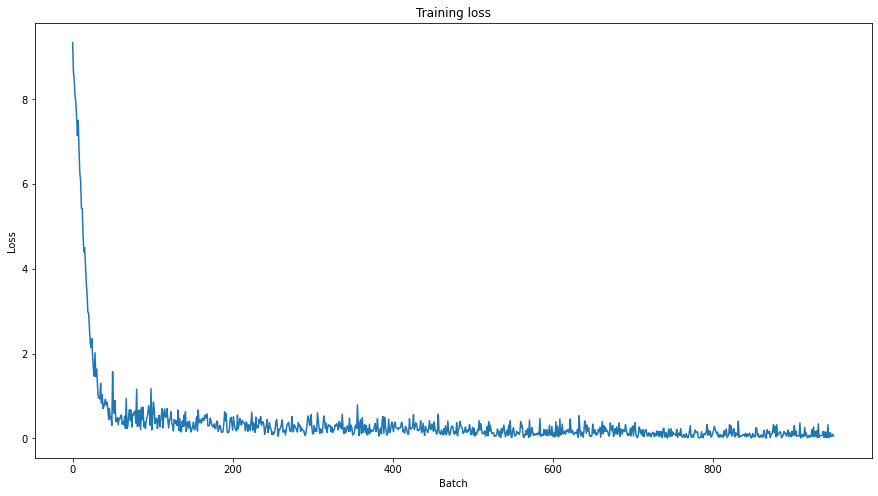

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Test model on testing data.

In [22]:
DATA_NAME = "EBA1415-SkinCancer-little-sentences.tsv"

df_test = pd.read_csv(DATA_PATH + DATA_NAME, delimiter='\t', header=0, names=['essay', 'relation', 's_num', 'sentence'])

df_test.head(50)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,R-1-50,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,R-1-2,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,R-1-2,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,R-2-3,3.2,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,R-5-50,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,R-5-50,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,R-2-50,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,R-3-50,7.2,There are two main reasons why people can deve...


Convert testing data labels to ternary.

In [23]:
relations_test_pd = df_test.relation.copy(deep=True)
df_ternary_test = df_test.copy(deep=True)

for i, rel in relations_test_pd.items():
  chain = rel.split("-")

  if chain[0] == "O":
    relations_test_pd.at[i] = 0
    continue
  
  chain = chain[1] + "," + chain[2]

  if chain in relations:
    relations_test_pd.at[i] = 1
  else: 
    relations_test_pd.at[i] = 2

df_ternary_test.relation = relations_test_pd
df_ternary_test.head(50)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,0,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,1,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,1,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,1,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,1,3.2,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,1,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,1,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,0,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,1,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,1,7.2,There are two main reasons why people can deve...


Identify duplicates in test set.


In [24]:
df_duplicate_sentences_test = df_ternary_test[df_ternary_test.s_num.astype(str).str.split('.', expand=True)[1] != '0']
df_duplicate_sentences_test.head(25)

,essay,relation,s_num,sentence
1,EBA1415_TFHC_4_SC_ES-05825,1,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,1,2.2,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,1,3.1,The reason the sun matters is because of the d...
4,EBA1415_TFHC_4_SC_ES-05825,1,3.2,The reason the sun matters is because of the d...
8,EBA1415_WSAL_2_SC_ES-05359,1,7.1,There are two main reasons why people can deve...
9,EBA1415_WSAL_2_SC_ES-05359,1,7.2,There are two main reasons why people can deve...
10,EBA1415_WSAL_2_SC_ES-05359,1,8.1,It's from radiation and direct sunlight.
11,EBA1415_WSAL_2_SC_ES-05359,1,8.2,It's from radiation and direct sunlight.
17,EBA1415_WSAL_2_SC_ES-05359,1,14.1,If the skin is getting too much radiation or s...
18,EBA1415_WSAL_2_SC_ES-05359,1,14.2,If the skin is getting too much radiation or s...


Remove duplicates from test set.

In [25]:
current = -1

same_arr_inds = []
drop_list = []

for i, row in df_duplicate_sentences_test.iterrows():
  s_num = str(df_duplicate_sentences_test.loc[i].s_num)
  first_num, second_num = s_num.split(".")

  if first_num != current:
    current = first_num

    if len(same_arr_inds) > 1:

      valid_flag = False
      invalid_flag = False

      for n in same_arr_inds:

        if df_duplicate_sentences_test.loc[n].relation == 1:
          valid_flag = True
          break

        if df_duplicate_sentences_test.loc[n].relation == -1:
          invalid_flag = True 

      left = same_arr_inds[0]
      right = same_arr_inds[1:]

      if valid_flag == True:
        df_duplicate_sentences_test.loc[left].relation = 1
      elif invalid_flag == True:
        df_duplicate_sentences_test.loc[left].relation = -1
      else:
        df_duplicate_sentences_test.loc[left].relation = 0

      drop_list += right   

    same_arr_inds = []
  same_arr_inds.append(i)

df_ternary_test.drop(drop_list, inplace=True)   

df_ternary_test.head(25)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,0,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,1,2.1,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,1,3.1,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,1,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,1,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,0,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,1,7.1,There are two main reasons why people can deve...
10,EBA1415_WSAL_2_SC_ES-05359,1,8.1,It's from radiation and direct sunlight.
12,EBA1415_WSAL_2_SC_ES-05359,1,9.0,Or just if you receive too much sunlight in ge...
13,EBA1415_WSAL_2_SC_ES-05359,1,10.0,"I read that the closer you are to the Equator,..."


We must grab the original labels to use later for the additional classification step.

In [26]:
inds = df_ternary_test.index.values.tolist()
df_multi_test = df_test.copy(deep=True)
df_multi_test = df_multi_test[df_multi_test.index.isin(inds)]
print("Test size:",len(df_multi_test))
df_multi_test.head(25)

Test size: 2224


,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,R-1-50,2.1,Some skin cancer can be caused by the location...
3,EBA1415_TFHC_4_SC_ES-05825,R-1-2,3.1,The reason the sun matters is because of the d...
5,EBA1415_TFHC_4_SC_ES-05825,R-5-50,4.0,Another cause of skin cancer is sunbrun.
6,EBA1415_TFHC_4_SC_ES-05825,R-5-50,5.0,While sunbrun isn't much to worie about you ca...
7,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,R-2-50,7.1,There are two main reasons why people can deve...
10,EBA1415_WSAL_2_SC_ES-05359,R-2-50,8.1,It's from radiation and direct sunlight.
12,EBA1415_WSAL_2_SC_ES-05359,R-2-50,9.0,Or just if you receive too much sunlight in ge...
13,EBA1415_WSAL_2_SC_ES-05359,R-1-2,10.0,"I read that the closer you are to the Equator,..."


We must reset the indexes so that they match up with the indexes of the test set predictions.

In [27]:
df_multi_test = df_multi_test.reset_index(drop=True)
df_multi_test.head(25)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
1,EBA1415_TFHC_4_SC_ES-05825,R-1-50,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,R-1-2,3.1,The reason the sun matters is because of the d...
3,EBA1415_TFHC_4_SC_ES-05825,R-5-50,4.0,Another cause of skin cancer is sunbrun.
4,EBA1415_TFHC_4_SC_ES-05825,R-5-50,5.0,While sunbrun isn't much to worie about you ca...
5,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
6,EBA1415_WSAL_2_SC_ES-05359,R-2-50,7.1,There are two main reasons why people can deve...
7,EBA1415_WSAL_2_SC_ES-05359,R-2-50,8.1,It's from radiation and direct sunlight.
8,EBA1415_WSAL_2_SC_ES-05359,R-2-50,9.0,Or just if you receive too much sunlight in ge...
9,EBA1415_WSAL_2_SC_ES-05359,R-1-2,10.0,"I read that the closer you are to the Equator,..."


Let's take a look at the class breakdown for the test set.

In [28]:
df_ternary_test["relation"].value_counts()

0    1204
1     972
2      48
Name: relation, dtype: int64

# Extract sentences and labels from test data.

In [29]:
sentences_test = df_ternary_test.sentence.values
sentences_test = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test]

tokenized_texts_test = [tokenizer.tokenize(sentence) for sentence in sentences_test]
labels_test = df_ternary_test.relation.values.astype(int)
labels_test

array([0, 1, 1, ..., 1, 0, 0])

Tokenize test set essays.

In [30]:
input_ids_test = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test]
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Set test set attention masks.

In [31]:
attention_masks_test = []

for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test.append(seq_mask)

Tensorize and load data.

In [32]:
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks_test)
prediction_labels = torch.tensor(labels_test)

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=BATCH_SIZE)

Evaluate test set.

In [33]:
model.eval()

predictions_test, true_labels_test = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test.append(logits_test)
  true_labels_test.append(label_ids_test)

Print confusion matrix.

In [34]:
from sklearn.metrics import confusion_matrix

flat_predictions_test = [item for sublist in predictions_test for item in sublist]
flat_predictions_test = np.argmax(flat_predictions_test, axis=1).flatten()
flat_true_labels_test = [item for sublist in true_labels_test for item in sublist]

y_pred = flat_predictions_test
y = flat_true_labels_test

stats = confusion_matrix(y, y_pred).ravel()

print("\t\t\t      Predicted\n")
print("\t\t\tNone\tValid\tInvalid")
print("\n\t\tNone\t{}     {}        {}".format(stats[0], stats[1], stats[2]))
print("      Actual")
print("\t\tValid\t{}      {}        {}".format(stats[3], stats[4], stats[5]))
print("\n\t\tInvalid\t {}       {}        {}".format(stats[6], stats[7], stats[8]))

			      Predicted

			None	Valid	Invalid

		None	1057     143        4
      Actual
		Valid	65      903        4

		Invalid	 6       20        22


Now we must isolate the valid and invalid predictions so that we can run them through the multilabel classifier.

In [35]:
# Get array of all instances predicted valid

test_pred_valid_inds = [i for i in range(len(y_pred)) if y_pred[i] == 1]
test_true_valid_inds = [i for i in range(len(y)) if y[i] == 1]
print("Predicted valid:",len(test_pred_valid_inds))
print("Actual valid:",len(test_true_valid_inds))

Predicted valid: 1066
Actual valid: 972


In [36]:
# Get array of all instances predicted invalid

test_pred_invalid_inds = [i for i in range(len(y_pred)) if y_pred[i] == 2 or y_pred[i] == 0]
test_true_invalid_inds = [i for i in range(len(y)) if y[i] == 2 or y_pred[i] == 0]
print("Predicted invalid:",len(test_pred_invalid_inds))
print("Actual invalid:",len(test_true_invalid_inds))

Predicted invalid: 1158
Actual invalid: 1170


In [37]:
# Create dataframe of valid predictions

df_multi_test_valid = df_multi_test.copy(deep=True)
df_multi_test_valid = df_multi_test_valid[df_multi_test_valid.index.isin(test_pred_valid_inds)]
print("Test size (valid predictions):",len(df_multi_test_valid))
df_multi_test_valid.head(25)

Test size (valid predictions): 1066


,essay,relation,s_num,sentence
1,EBA1415_TFHC_4_SC_ES-05825,R-1-50,2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,R-1-2,3.1,The reason the sun matters is because of the d...
3,EBA1415_TFHC_4_SC_ES-05825,R-5-50,4.0,Another cause of skin cancer is sunbrun.
4,EBA1415_TFHC_4_SC_ES-05825,R-5-50,5.0,While sunbrun isn't much to worie about you ca...
6,EBA1415_WSAL_2_SC_ES-05359,R-2-50,7.1,There are two main reasons why people can deve...
7,EBA1415_WSAL_2_SC_ES-05359,R-2-50,8.1,It's from radiation and direct sunlight.
9,EBA1415_WSAL_2_SC_ES-05359,R-1-2,10.0,"I read that the closer you are to the Equator,..."
10,EBA1415_WSAL_2_SC_ES-05359,R-1-50,11.0,"Also, from looking at the chart, it showed tha..."
11,EBA1415_WSAL_2_SC_ES-05359,R-3-50,12.0,"Also, radiation palys a part in skin cancer an..."
13,EBA1415_WSAL_2_SC_ES-05359,R-3-4,14.1,If the skin is getting too much radiation or s...


In [38]:
# Going to edit iteratively (lazily)...will fix later.

for i, row in df_multi_test_valid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_multi_test_valid.at[i, "relation"] = r
  
df_multi_test_valid.head()

,essay,relation,s_num,sentence
1,EBA1415_TFHC_4_SC_ES-05825,"1,50",2.1,Some skin cancer can be caused by the location...
2,EBA1415_TFHC_4_SC_ES-05825,"1,2",3.1,The reason the sun matters is because of the d...
3,EBA1415_TFHC_4_SC_ES-05825,"5,50",4.0,Another cause of skin cancer is sunbrun.
4,EBA1415_TFHC_4_SC_ES-05825,"5,50",5.0,While sunbrun isn't much to worie about you ca...
6,EBA1415_WSAL_2_SC_ES-05359,"2,50",7.1,There are two main reasons why people can deve...


In [39]:
# Create dataframe of invalid predictions

df_multi_test_invalid = df_multi_test.copy(deep=True)
df_multi_test_invalid = df_multi_test_invalid[df_multi_test_invalid.index.isin(test_pred_invalid_inds)]
print("Test size (invalid predictions):",len(df_multi_test_invalid))
df_multi_test_invalid.head(25)

Test size (invalid predictions): 1158


,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
5,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,R-2-50,9.0,Or just if you receive too much sunlight in ge...
12,EBA1415_WSAL_2_SC_ES-05359,R-3-4,13.0,If you have a harmful exposure to UVb radiatio...
16,EBA1415_WSAL_2_SC_ES-05359,O,17.0,These are some ways the body can develop skin ...
17,EBA1415_RDCS_1_SC_ES-4700,O,18.0,There are 3 main differences of skin cancer.
18,EBA1415_RDCS_1_SC_ES-4700,O,19.0,"Basal cell carcinoma, squamous cell carcinoma,..."
19,EBA1415_RDCS_1_SC_ES-4700,O,20.0,"With all of these diseases, Basal and Squamous..."
20,EBA1415_RDCS_1_SC_ES-4700,R-2-50,21.0,But malignant melanoma is the mostly taken for...
22,EBA1415_RDCS_1_SC_ES-4700,O,23.0,So like this includes the northern third of au...


In [40]:
# Going to edit iteratively (lazily)...will fix later.

for i, row in df_multi_test_invalid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_multi_test_invalid.at[i, "relation"] = r
  
df_multi_test_invalid.head(25)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_4_SC_ES-05825,O,1.0,The lead to skin cancer differ on a few things...
5,EBA1415_TFHC_4_SC_ES-05825,O,6.0,Didn't finished
8,EBA1415_WSAL_2_SC_ES-05359,"2,50",9.0,Or just if you receive too much sunlight in ge...
12,EBA1415_WSAL_2_SC_ES-05359,"3,4",13.0,If you have a harmful exposure to UVb radiatio...
16,EBA1415_WSAL_2_SC_ES-05359,O,17.0,These are some ways the body can develop skin ...
17,EBA1415_RDCS_1_SC_ES-4700,O,18.0,There are 3 main differences of skin cancer.
18,EBA1415_RDCS_1_SC_ES-4700,O,19.0,"Basal cell carcinoma, squamous cell carcinoma,..."
19,EBA1415_RDCS_1_SC_ES-4700,O,20.0,"With all of these diseases, Basal and Squamous..."
20,EBA1415_RDCS_1_SC_ES-4700,"2,50",21.0,But malignant melanoma is the mostly taken for...
22,EBA1415_RDCS_1_SC_ES-4700,O,23.0,So like this includes the northern third of au...


Now we will fine-tune a BERT model just for the valid relations.

In [41]:
# First must edit relations 

df_valid = df.copy(deep=True)

# Going to edit iteratively (lazily)...will fix later.

for i, row in df_valid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_valid.at[i, "relation"] = r
  
df_valid.head()

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,"1,2",5.0,Latitude and direct sunlight would be the cols...


In [42]:
# Now isolate the valid ones

df_valid = df_valid[df_valid['relation'].isin(relations)]
df_valid.head()

,essay,relation,s_num,sentence
4,EBA1415_TFHC_1_SC_ES-05947,"1,2",5.0,Latitude and direct sunlight would be the cols...
5,EBA1415_TFHC_1_SC_ES-05947,"1,2",6.0,The most yearound direct sunlight occurs betwe...
24,EBA1415_SDMK_6_SC_ES-06292,"1,50",25.0,Where you are located can tell how much of a r...
25,EBA1415_SDMK_6_SC_ES-06292,"1,2",26.1,If you are between the Tropics of Cancer and c...
26,EBA1415_SDMK_6_SC_ES-06292,"2,3",26.2,If you are between the Tropics of Cancer and c...


In [43]:
# Create sentence and label lists
sentences = df_valid.sentence.values

# Add special tokens at the beginning and end of each sentence to comply with BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_valid.relation.values

In [44]:
# Now that our [CLS] and [SEP] tokens are in place, we are ready for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'latitude', 'and', 'direct', 'sunlight', 'would', 'be', 'the', 'col', '##ser', 'you', 'are', 'to', 'the', 'equator', 'the', 'more', 'consistent', 'direct', 'sunlight', 'there', 'will', 'be', '.', '[SEP]']


In [45]:
'''
For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set
'''

# For now, we will simply delete the tokenized_texts greater than MAX_LEN.

# We need to strip out the sentences greater than MAX_LEN tokens
original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))

Removed 4 sentences greater than 128


In [46]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [47]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [48]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [49]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels))
labels = [relations.index(l) for l in labels]
print("New labels: ",str(labels))

Old labels:  ['1,2', '1,2', '1,50', '1,2', '2,3', '3,4', '5,6', '2,50', '2,50', '1,2', '1,50', '5,6', '4,5', '1,2', '1,2', '3,50', '1,2', '2,5', '5,50', '2,3', '3,4', '5,50', '3,50', '1,50', '2,50', '1,50', '4,50', '1,50', '2,50', '1,50', '2,50', '1,50', '5,50', '5,50', '4,5', '5,50', '3,50', '5,6', '2,5', '2,5', '1,2', '3,4', '2,3', '2,5', '3,50', '5,50', '5,50', '5,50', '5,6', '6,50', '5,6', '4,5', '4,5', '5,50', '1,50', '1,2', '2,50', '2,4', '1,2', '5,50', '1,5', '5,6', '6,50', '1,50', '2,50', '1,2', '2,50', '2,3', '11,50', '11,12', '11,50', '5,50', '5,6', '4,5', '4,5', '5,6', '5,50', '4,50', '4,50', '1,2', '2,3', '3,4', '1,50', '5,50', '2,50', '2,3', '3,50', '3,4', '3,4', '5,50', '5,50', '2,50', '2,50', '2,50', '2,4', '1,50', '3,50', '5,50', '2,50', '5,50', '1,2', '5,6', '6,50', '5,50', '5,50', '2,50', '2,50', '4,5', '5,6', '6,50', '5,50', '2,50', '1,2', '2,50', '2,3', '1,2', '5,50', '5,6', '4,5', '5,6', '5,6', '6,50', '5,50', '4,5', '5,50', '3,50', '6,50', '5,50', '5,50', '4,5', '

In [50]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [51]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [52]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [53]:
# This is where the fine-tuning comes in. We must train the model for our specific task.

# We will first modify pre-trained BERT for our specific task, then continue training on our data until the entire model
#   is well-suited for our task.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [54]:
'''
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [55]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


In [56]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 2.8826052742404538


Epoch:  25%|██▌       | 1/4 [00:46<02:20, 46.97s/it]

Validation Accuracy: 0.5786830357142857
Train loss: 1.2746053012934597


Epoch:  50%|█████     | 2/4 [01:33<01:33, 46.93s/it]

Validation Accuracy: 0.5611049107142857
Train loss: 1.0671401828319043


Epoch:  75%|███████▌  | 3/4 [02:20<00:46, 46.91s/it]

Validation Accuracy: 0.5764508928571429
Train loss: 0.9487787764389198


Epoch: 100%|██████████| 4/4 [03:07<00:00, 46.85s/it]

Validation Accuracy: 0.5474330357142857


Now we will evaluate the instances guessed valid with the valid-trained BERT.

In [57]:
sentences_test_valid = df_multi_test_valid.sentence.values
sentences_test_valid = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test_valid]

tokenized_texts_test_valid = [tokenizer.tokenize(sentence) for sentence in sentences_test_valid]
labels_test_valid = df_multi_test_valid.relation.values
labels_test_valid[:50]

array(['1,50', '1,2', '5,50', '5,50', '2,50', '2,50', '1,2', '1,50',
       '3,50', '3,4', '5,50', '6,50', '2,50', '12,3', '3,50', '3,6',
       '3,5', '5,6', '5,6', '1,2', '1,50', '5,50', '2,5', '5,6', '5,50',
       '2,50', '2,50', '5,50', '6,5', '2,50', '2,50', '1,2', '1,2',
       '1,50', '2,6', '11,12', '11,12', '11,12', '5,6', '5,6', '1,50',
       '1,2', 'O', '3,6', '3,50', '5,6', '4,5', '6,50', 'O', '5,50'],
      dtype=object)

In [58]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels_test_valid[:50]))
labels_test_valid = [relations.index(l) if l in relations else 999 for l in labels_test_valid]
print("New labels: ",str(labels_test_valid))

Old labels:  ['1,50' '1,2' '5,50' '5,50' '2,50' '2,50' '1,2' '1,50' '3,50' '3,4' '5,50'
 '6,50' '2,50' '12,3' '3,50' '3,6' '3,5' '5,6' '5,6' '1,2' '1,50' '5,50'
 '2,5' '5,6' '5,50' '2,50' '2,50' '5,50' '6,5' '2,50' '2,50' '1,2' '1,2'
 '1,50' '2,6' '11,12' '11,12' '11,12' '5,6' '5,6' '1,50' '1,2' 'O' '3,6'
 '3,50' '5,6' '4,5' '6,50' 'O' '5,50']
New labels:  [5, 0, 19, 19, 10, 10, 0, 5, 14, 11, 19, 25, 10, 999, 14, 13, 12, 18, 18, 0, 5, 19, 8, 18, 19, 10, 10, 19, 999, 10, 10, 0, 0, 5, 9, 20, 20, 20, 18, 18, 5, 0, 999, 13, 14, 18, 15, 25, 999, 19, 10, 8, 10, 6, 11, 14, 19, 15, 999, 0, 0, 6, 19, 15, 18, 19, 10, 7, 999, 999, 10, 6, 999, 18, 999, 10, 10, 0, 0, 11, 15, 18, 18, 0, 19, 25, 18, 0, 5, 25, 15, 18, 17, 16, 25, 5, 0, 20, 999, 20, 5, 0, 0, 18, 10, 10, 999, 18, 18, 14, 19, 999, 19, 10, 10, 999, 20, 999, 999, 999, 18, 18, 5, 0, 0, 1, 999, 999, 999, 14, 6, 11, 10, 999, 999, 20, 999, 20, 10, 10, 0, 10, 11, 999, 0, 0, 20, 20, 18, 18, 15, 10, 14, 5, 0, 0, 6, 20, 20, 19, 19, 999, 14, 20, 5,

In [59]:
input_ids_test_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test_valid]
input_ids_test_valid = pad_sequences(input_ids_test_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [60]:
attention_masks_test_valid = []

for seq in input_ids_test_valid:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test_valid.append(seq_mask)

In [61]:
prediction_inputs_valid = torch.tensor(input_ids_test_valid)
prediction_masks_valid = torch.tensor(attention_masks_test_valid)
prediction_labels_valid = torch.tensor(labels_test_valid)

prediction_data_valid = TensorDataset(prediction_inputs_valid, prediction_masks_valid, prediction_labels_valid)
prediction_sampler_valid = SequentialSampler(prediction_data_valid)
prediction_dataloader_valid = DataLoader(prediction_data_valid, sampler=prediction_sampler_valid, batch_size=BATCH_SIZE)

In [62]:
model.eval()

predictions_test_valid, true_labels_test_valid = [], []

# Predict 
for batch in prediction_dataloader_valid:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test_valid.append(logits_test)
  true_labels_test_valid.append(label_ids_test)

In [63]:
flat_predictions_test_valid = [item for sublist in predictions_test_valid for item in sublist]
flat_predictions_test_valid = np.argmax(flat_predictions_test_valid, axis=1).flatten()
flat_true_labels_test_valid = [item for sublist in true_labels_test_valid for item in sublist]

y_pred_valid = flat_predictions_test_valid
y_valid = flat_true_labels_test_valid

print(y_pred_valid)
print(y_valid)

[ 5  0 19 ... 19 19 19]
[5, 0, 19, 19, 10, 10, 0, 5, 14, 11, 19, 25, 10, 999, 14, 13, 12, 18, 18, 0, 5, 19, 8, 18, 19, 10, 10, 19, 999, 10, 10, 0, 0, 5, 9, 20, 20, 20, 18, 18, 5, 0, 999, 13, 14, 18, 15, 25, 999, 19, 10, 8, 10, 6, 11, 14, 19, 15, 999, 0, 0, 6, 19, 15, 18, 19, 10, 7, 999, 999, 10, 6, 999, 18, 999, 10, 10, 0, 0, 11, 15, 18, 18, 0, 19, 25, 18, 0, 5, 25, 15, 18, 17, 16, 25, 5, 0, 20, 999, 20, 5, 0, 0, 18, 10, 10, 999, 18, 18, 14, 19, 999, 19, 10, 10, 999, 20, 999, 999, 999, 18, 18, 5, 0, 0, 1, 999, 999, 999, 14, 6, 11, 10, 999, 999, 20, 999, 20, 10, 10, 0, 10, 11, 999, 0, 0, 20, 20, 18, 18, 15, 10, 14, 5, 0, 0, 6, 20, 20, 19, 19, 999, 14, 20, 5, 0, 0, 10, 7, 10, 0, 1, 14, 0, 1, 999, 13, 20, 20, 999, 18, 18, 19, 5, 999, 5, 10, 18, 14, 0, 0, 0, 7, 0, 999, 999, 12, 5, 6, 999, 19, 0, 6, 999, 10, 19, 18, 19, 19, 19, 10, 5, 0, 0, 19, 15, 18, 18, 10, 10, 14, 999, 10, 15, 19, 10, 5, 10, 0, 0, 10, 19, 12, 6, 11, 25, 19, 19, 999, 0, 999, 20, 22, 14, 5, 10, 5, 0, 10, 999, 8, 999, 25, 

Extract stats.

In [64]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73       110
           1       0.62      0.57      0.59        14
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           5       0.74      0.85      0.79        84
           6       0.75      0.71      0.73        34
           7       0.50      0.38      0.43        13
           8       0.50      0.48      0.49        21
           9       0.00      0.00      0.00         1
          10       0.50      0.79      0.61       102
          11       0.51      0.90      0.65        40
          12       1.00      0.11      0.20         9
          13       0.00      0.00      0.00         8
          14       0.76      0.71      0.74        55
          15       0.60      0.88      0.71        41
          16       0.00      0.00      0.00         7
          17       0.28      0.36      0.31        14
          18       0.63    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extract accuracy of valid relations.

In [65]:
p = 0
n = 0
for i in range(len(y_pred_valid)):
  if y_pred_valid[i] == y_valid[i]:
    p += 1
  else:
    n += 1

print("Valid guessed correctly:",p)
print("Valid guessed incorrectly:",n)
print("Total valid:", p + n)
print("Valid accuracy:", p/(p+n))

Valid guessed correctly: 655
Valid guessed incorrectly: 411
Total valid: 1066
Valid accuracy: 0.6144465290806754


Now for the invalid relations.

In [66]:
# First must edit relations 

df_valid = df.copy(deep=True)

# Going to edit iteratively (lazily)...will fix later.

for i, row in df_valid.iterrows():
  r = row.relation

  if r == 'O': continue
  r_split = r.split("-")
  r = r_split[1] + "," + r_split[2]
  df_valid.at[i, "relation"] = r
  
df_valid.head()

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
4,EBA1415_TFHC_1_SC_ES-05947,"1,2",5.0,Latitude and direct sunlight would be the cols...


In [67]:
# Now isolate the valid ones

df_valid = df_valid[~df_valid['relation'].isin(relations)]
df_valid.head(25)

,essay,relation,s_num,sentence
0,EBA1415_TFHC_1_SC_ES-05947,O,1.0,"This essay is about skin damage, latitude and ..."
1,EBA1415_TFHC_1_SC_ES-05947,O,2.0,The skin damage is on our bodies that have num...
2,EBA1415_TFHC_1_SC_ES-05947,O,3.0,There are three main varieties of skin cancer ...
3,EBA1415_TFHC_1_SC_ES-05947,O,4.0,That would be what skin damage is.
6,EBA1415_TFHC_1_SC_ES-05947,O,7.0,That would be latitude and direct sunlight.
7,EBA1415_TFHC_1_SC_ES-05947,O,8.0,Your skin protects you is that it acts as a wa...
8,EBA1415_TFHC_1_SC_ES-05947,"12,3",9.0,Your skin does have some denses against solar ...
9,EBA1415_TFHC_1_SC_ES-05947,O,10.0,That would be your skin protects you.
10,EBA1415_TFHC_1_SC_ES-05947,O,11.0,Sunburn can happen when the body directs blood...
11,EBA1415_TFHC_1_SC_ES-05947,O,12.0,There are severe sunburn is called sun poisoning.


In [68]:
# Create sentence and label lists
sentences = df_valid.sentence.values

# Add special tokens at the beginning and end of each sentence to comply with BERT
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df_valid.relation.values

In [69]:
# Now that our [CLS] and [SEP] tokens are in place, we are ready for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("First sentence tokenized: ",tokenized_texts[0])

First sentence tokenized:  ['[CLS]', 'this', 'essay', 'is', 'about', 'skin', 'damage', ',', 'latitude', 'and', 'direct', 'sunlight', ',', 'skin', 'cancer', 'and', 'latitude', ',', 'your', 'skin', 'protects', 'you', 'and', 'about', 'sun', '##burn', '##s', '.', '[SEP]']


In [70]:
'''
For each tokenized input sentence, we need to create:

1. input ids:
    a sequence of integers identifying each input token to its index number 
    in the BERT tokenizer vocabulary

2. segment mask: (optional) a sequence of 1s and 0s used to identify whether the input is one 
    sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. 
    For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 
    1 for each token of the second sentence

3. attention mask: (optional) 
    a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens 

4. labels: based on the labels from the data set
'''

# For now, we will simply delete the tokenized_texts greater than MAX_LEN.

# We need to strip out the sentences greater than MAX_LEN tokens
original_length = len(tokenized_texts)

labels = [labels[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
tokenized_texts = [tokenized_texts[i] for i in range(len(tokenized_texts)) if len(tokenized_texts[i]) <= MAX_LEN]
print("Removed {0} sentences greater than {1}".format(original_length - len(tokenized_texts),MAX_LEN))

Removed 8 sentences greater than 128


In [71]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [72]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [73]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [74]:
# At this point we must convert our labels from strings to ints (required for tensorization)

# First we are going to create an array of all possible labels
label_types_invalid = {}
for i in range(len(labels)):
  if labels[i] not in label_types_invalid:
    label_types_invalid.update({labels[i] : len(label_types_invalid)})
print("Total labels_types: {0}\nLabels: {1}".format(len(label_types_invalid),str(label_types_invalid)))

Total labels_types: 28
Labels: {'O': 0, '12,3': 1, '4,4': 2, '5,4': 3, '12,2': 4, '6,5': 5, '5,5': 6, '12,12': 7, '11,3': 8, '12,5': 9, '11,5': 10, '50,2': 11, '2,2': 12, '11,4': 13, '6,4': 14, '50,5': 15, '12,4': 16, '5,11': 17, '50,4': 18, '6,3': 19, '4,11': 20, '2,1': 21, '50,3': 22, '5,12': 23, '2,11': 24, '3,11': 25, '3,2': 26, '50,1': 27}


In [75]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels))
labels = [label_types_invalid[l] if l in label_types_invalid else 999 for l in labels]
print("New labels: ",str(labels))

Old labels:  ['O', 'O', 'O', 'O', 'O', 'O', '12,3', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '12,3', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '4,4', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '12,3', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '5,4', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '5,4', 'O', '

In [76]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [77]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [78]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [79]:
# This is where the fine-tuning comes in. We must train the model for our specific task.

# We will first modify pre-trained BERT for our specific task, then continue training on our data until the entire model
#   is well-suited for our task.

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels))
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [80]:
'''
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [81]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP)

t_total value of -1 results in schedule not being applied


In [82]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(EPOCHS, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.9899495955689677


Epoch:  25%|██▌       | 1/4 [00:45<02:17, 45.75s/it]

Validation Accuracy: 0.951171875
Train loss: 0.23592376101296395


Epoch:  50%|█████     | 2/4 [01:31<01:31, 45.75s/it]

Validation Accuracy: 0.947265625
Train loss: 0.16855737739575227


Epoch:  75%|███████▌  | 3/4 [02:17<00:45, 45.73s/it]

Validation Accuracy: 0.97265625
Train loss: 0.13615862545889934


Epoch: 100%|██████████| 4/4 [03:02<00:00, 45.71s/it]

Validation Accuracy: 0.97265625


In [83]:
sentences_test_valid = df_multi_test_invalid.sentence.values
sentences_test_valid = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_test_valid]

tokenized_texts_test_valid = [tokenizer.tokenize(sentence) for sentence in sentences_test_valid]
labels_test_valid = df_multi_test_invalid.relation.values
labels_test_valid[:50]

array(['O', 'O', '2,50', '3,4', 'O', 'O', 'O', 'O', '2,50', 'O', '1,50',
       'O', '3,5', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '5,50', 'O', 'O',
       'O', 'O', 'O', 'O', '1,50', 'O', 'O', '2,5', 'O', '5,50', 'O', 'O',
       'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '2,50',
       '5,6', 'O'], dtype=object)

In [84]:
# Now map each label to its corresponding integer
print("Old labels: ",str(labels_test_valid[:50]))
labels_test_valid = [label_types_invalid[l] if l in label_types_invalid else 999 for l in labels_test_valid]
print("New labels: ",str(labels_test_valid))

Old labels:  ['O' 'O' '2,50' '3,4' 'O' 'O' 'O' 'O' '2,50' 'O' '1,50' 'O' '3,5' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' '5,50' 'O' 'O' 'O' 'O' 'O' 'O' '1,50' 'O' 'O' '2,5'
 'O' '5,50' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' '2,50'
 '5,6' 'O']
New labels:  [0, 0, 999, 999, 0, 0, 0, 0, 999, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 999, 0, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 999, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 999, 0, 0, 999, 

In [85]:
input_ids_test_valid = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts_test_valid]
input_ids_test_valid = pad_sequences(input_ids_test_valid, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [86]:
attention_masks_test_valid = []

for seq in input_ids_test_valid:
  seq_mask = [float(i>0) for i in seq]
  attention_masks_test_valid.append(seq_mask)

In [87]:
prediction_inputs_valid = torch.tensor(input_ids_test_valid)
prediction_masks_valid = torch.tensor(attention_masks_test_valid)
prediction_labels_valid = torch.tensor(labels_test_valid)

prediction_data_valid = TensorDataset(prediction_inputs_valid, prediction_masks_valid, prediction_labels_valid)
prediction_sampler_valid = SequentialSampler(prediction_data_valid)
prediction_dataloader_valid = DataLoader(prediction_data_valid, sampler=prediction_sampler_valid, batch_size=BATCH_SIZE)

In [88]:
model.eval()

predictions_test_valid, true_labels_test_valid = [], []

# Predict 
for batch in prediction_dataloader_valid:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits_test = logits.detach().cpu().numpy()
  label_ids_test = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions_test_valid.append(logits_test)
  true_labels_test_valid.append(label_ids_test)

In [89]:
flat_predictions_test_valid = [item for sublist in predictions_test_valid for item in sublist]
flat_predictions_test_valid = np.argmax(flat_predictions_test_valid, axis=1).flatten()
flat_true_labels_test_valid = [item for sublist in true_labels_test_valid for item in sublist]

y_pred_valid = flat_predictions_test_valid
y_valid = flat_true_labels_test_valid

print(y_pred_valid)
print(y_valid)

[0 0 0 ... 0 0 0]
[0, 0, 999, 999, 0, 0, 0, 0, 999, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 999, 0, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 999, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 999, 0, 0, 999, 0, 0, 999, 999, 0, 6, 6, 0, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 999, 999, 0, 0, 0, 0, 999, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred_valid))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1061
           1       0.94      0.89      0.92        19
           3       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
         999       0.00      0.00      0.00        72

    accuracy                           0.93      1158
   macro avg       0.40      0.37      0.38      1158
weighted avg       0.87      0.93      0.90      1158



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
p_i = 0
n_i = 0
for i in range(len(y_pred_valid)):
  if y_pred_valid[i] == y_valid[i]:
    p_i += 1
  else:
    n_i += 1

print("Invalid guessed correctly:",p_i)
print("Invalid guessed incorrectly:",n_i)
print("Total invalid:", p_i + n_i)
print("Invalid accuracy:", p_i/(p_i+n_i))

Invalid guessed correctly: 1079
Invalid guessed incorrectly: 79
Total invalid: 1158
Invalid accuracy: 0.9317789291882557


In [92]:
print("Valid guessed correctly:",p)
print("Valid guessed incorrectly:",n)
print("Total valid:", p + n)
print("Valid accuracy:", p/(p+n))

Valid guessed correctly: 655
Valid guessed incorrectly: 411
Total valid: 1066
Valid accuracy: 0.6144465290806754


Total accuracy

In [93]:
total_preds =  p + n + p_i + n_i
print("Total guesses:", total_preds)

print("\nCorrect valid guesses:", p)
print("Incorrect valid guesses:", n)
print("Total valid guesses:", p + n)
print("Valid accuracy:", p/(p+n))

print("\nCorrect invalid guesses:", p_i)
print("Incorrect invalid guesses:", n_i)
print("Total invalid guesses:", p_i + n_i)
print("Invalid accuracy:", p_i/(p_i+n_i) if p_i+n_i else 0)

print("\nTotal accuracy:", (p+p_i)/total_preds)

Total guesses: 2224

Correct valid guesses: 655
Incorrect valid guesses: 411
Total valid guesses: 1066
Valid accuracy: 0.6144465290806754

Correct invalid guesses: 1079
Incorrect invalid guesses: 79
Total invalid guesses: 1158
Invalid accuracy: 0.9317789291882557

Total accuracy: 0.7796762589928058
